In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
from os import listdir, getcwd
from os.path import isfile, join
from math import radians,sin

In [2]:
def great_circle_array(clon,clat,XLON,XLAT):
    """
    clon and clat are the target point (in degrees) to be compared to every point in XLON and XLAT
    XLON and XLAT should be the result of meshgrid meaning they are both 2D (in degrees)
    Out put is a 2D array of Great Circle Distances (GCD) from each point to the target point in meters
    """
    rearth = 6371000 #meters
    clon,clat = map(radians,[clon,clat])
    XLON,XLAT = map(np.radians,[XLON,XLAT])
    
    return rearth * ( np.arccos(sin(clat) * np.sin(XLAT) + np.cos(clat) * np.cos(XLAT) * np.cos(clon - XLON)) )

def great_circle_list(clon,clat,XLON,XLAT):
    """
    clon and clat are the target point (in degrees) to be compared to every point in XLON and XLAT
    XLON and XLAT should be the list of points that make up the front
    Out put is a list of Great Circle Distances (GCD) from each point to the target point in meters
    """
    rearth = 6371000 #meters
    clon,clat = map(radians,[clon,clat])
    XLON,XLAT = map(np.radians,[XLON,XLAT])
    
    return rearth * ( np.arccos(sin(clat) * np.sin(XLAT) + np.cos(clat) * np.cos(XLAT) * np.cos(clon - XLON)) )

def GCD_m2deg(GCD):
    rearth = 6371000 #meters
    return (GCD / (2*np.pi*rearth)) * 360

def GCD_deg2m(GCD):
    rearth = 6371000 #meters
    return (GCD / 360) * (2*np.pi*rearth)

In [3]:
path = 'WPC_CODSUS/lores/2003'
onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
onlyfiles.sort()

In [45]:
with open(path+'/'+onlyfiles[5]) as f:
    lines = f.readlines()
f.close()

In [46]:
lines

['\n',
 'CODED SURFACE FRONTAL POSITIONS\n',
 'NWS HYDROMETEOROLOGICAL PREDICTION CENTER CAMP SPRINGS MD\n',
 '1000 PM EST ??? JAN 03 2003\n',
 '\n',
 'VALID 010403Z\n',
 'HIGHS 1033 39108 1030 46116 1024 3491 1025 2595 1022 31128 1028 3054 1029 \n',
 '5170 1019 68104 \n',
 'LOWS 965 59157 997 3972 1008 5097 1007 51105 972 5543 975 5840 1007 7791 956 \n',
 '48142 1009 6299 1010 6189 1002 76153 \n',
 'WARM WK 5098 4897 4697 4497 4396 4195 \n',
 'TROF 4398 4198 3899 33105 \n',
 'STNRY WK 57115 57120 57124 57128 58132 59136 60141 61145 62149 62152 \n',
 '61156 59159 57160 57163 \n',
 'OCFNT WK 3872 3971 3970 \n',
 'WARM WK 3970 3868 3866 3764 3762 3659 \n',
 'COLD WK 3970 3570 3172 2973 2675 2378 2181 1983 1686 \n',
 'COLD WK 4729 4430 4032 4032 3735 3640 3545 3450 3556 3659 \n',
 'STNRY WK 57163 56166 56169 56175 56178 55177 \n',
 'STNRY WK 5098 50100 50101 51102 52105 54107 56111 57115 \n',
 'TROF 4582 4480 4278 4075 3872 \n',
 'OCFNT WK 5841 5737 5634 5432 5230 4929 4729 \n',
 'TROF 55

In [47]:
FRONT_coords = []
number = 0
while number < len(lines):
    if len(lines[number])==1:
        number+=1
    elif lines[number].split()[0] in ['WARM','STNRY','COLD','OCFNT']:
        coordlist = [lines[number].split()[0],lines[number].split()[1]]
        if lines[number+1][0].isdigit():
            front_data = lines[number].split() + lines[number+1].split()
            number+=1
        else:
            front_data = lines[number].split()
        for coords in front_data[2:]:
            coordlist.append([int(coords[:2]),int(coords[2:])])
        FRONT_coords.append(coordlist)
        number+=1
    else:
        number+=1

In [48]:
def ExtractPlotData(frt):
    lats = []
    lons = []
    for co in frt[2:]:
        lats.append(co[0])
        lons.append(-1*co[1])
        
    if frt[0] == 'WARM':
        typ = 'red'
    elif frt[0] == 'STNRY':
        typ = 'green'
    elif frt[0] == 'COLD':
        typ = 'blue'
    elif frt[0] == 'OCFNT':
        typ = 'violet'
        
    return lons,lats,typ

In [49]:
# COMPUTES THE DISTANCE FROM A PEX TO THE END POINTS AND MID-POINT OF EACH FRONTAL SEGMENT AND RETURNS THE MINIMUM DISTANCE IN GREAT CIRCLE DEGREES

def GCD_Point2Front_AtTime(clon,clat,frts):
    mindist = []
    for frt in frts:
        lons,lats,_ = ExtractPlotData(frt)
        gcds = GCD_m2deg(great_circle_list(clon,clat,np.array(lons),np.array(lats)))
        mindist.append(np.min(gcds))
        # WHAT IF WE ALSO CHECK THE MID POINTS
        mlons = []
        mlats = []
        for gg in range(len(lons)-1):
            mlons.append((lons[gg]+lons[gg+1])/2)
            mlats.append((lats[gg]+lats[gg+1])/2)
        gcds = GCD_m2deg(great_circle_list(clon,clat,np.array(mlons),np.array(mlats)))
        mindist.append(np.min(gcds))
        
    return min(mindist)

In [50]:
llats = np.arange(23,55)
llons = np.arange(-127,-64)
dtf = np.zeros((len(llats),len(llons)))
for y in range(len(llats)):
    for x in range(len(llons)):
        dtf[y,x] = GCD_Point2Front_AtTime(llons[x],llats[y],FRONT_coords)

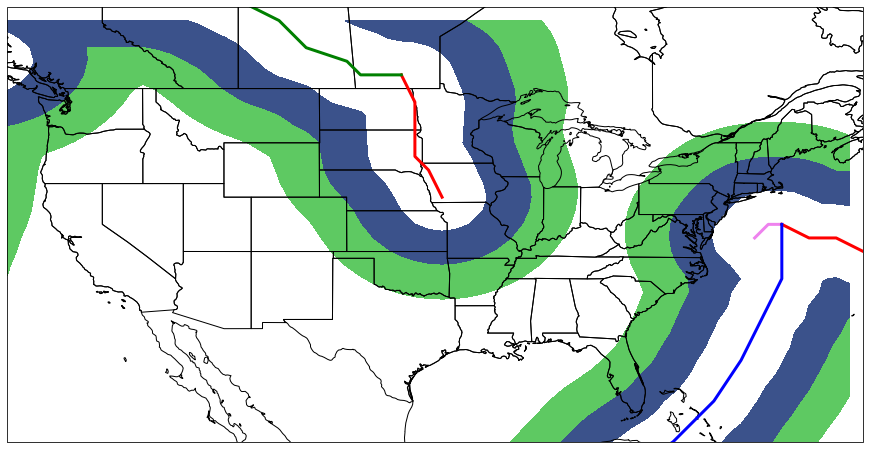

In [51]:
proj = ccrs.PlateCarree()
MyFigure = plt.figure(figsize = (16,8))
ax = MyFigure.add_subplot(1,1,1,projection=proj)
ax.set_extent([-127, -64, 23, 55], crs=proj)
for frt in FRONT_coords:
    [lons,lats,typ] = ExtractPlotData(frt)
    ax.plot(lons,lats,color = typ,linewidth=3)
ax.contourf(llons,llats,dtf,levels=[2.5,5,7.5])
# plt.colorbar(c,orientation='horizontal')
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'))

# WITHIN ABOUT THREE GCD FROM A FRONT IT MATTERS THAT WE'RE ONLY USING THE POINTS THAT DEFINE THE FRONT RATHER THAN THE ENTIRE LINE
# OUTSIDE OF THREE GCD IT DOESN'T SEEM TO MATTER